<a href="https://colab.research.google.com/github/dlwjdals102/Big-Data-Project/blob/main/Steam_Game_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steam 게임 분석

In [25]:
!pip install requests beautifulsoup4 pandas
!pip install numpy

1. 데이터 수집



In [2]:
# 게임 순위 (플레이어 수 기준) TOP 200

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# SteamCharts의 단일 페이지를 스크랩하는 기능
def scrape_steamcharts(page=1):
    url = f"https://steamcharts.com/top/p.{page}"  # Page-specific URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # 게임 데이터가 포함된 테이블을 찾습니다.
    table = soup.find('table', {'class': 'common-table'})
    rows = table.find_all('tr')[1:]  # Skip the header row

    # 행별로 데이터 추출
    data = []
    for row in rows:
        cols = row.find_all('td')
        try:
            game_data = {
                'Rank': cols[0].text.strip(),
                'Name': cols[1].text.strip(),
                'Current Players': int(cols[2].text.replace(',', '').strip()),
                'Peak Players': int(cols[4].text.replace(',', '').strip()),
                'Hours Played': int(cols[5].text.replace(',', '').strip())
            }
            data.append(game_data)
        except (IndexError, ValueError) as e:
            print(f"Skipping row due to error: {e}")
            continue

    return data

# 여러 페이지에서 데이터 스크랩
all_data = []
num_pages = 8  # 더 많은 데이터를 스크랩하려면 페이지 수를 조정하세요.
for page in range(1, num_pages + 1):
    print(f"Scraping page {page}...")
    all_data.extend(scrape_steamcharts(page))
    time.sleep(2)  # 서버 과부하를 방지하려면 지연을 추가하세요.

# DataFrame으로 변환
df = pd.DataFrame(all_data)

# 데이터 세트 저장
df.to_csv('steamcharts_data.csv', index=False)

# 처음 몇 행 표시
print(df.head())

Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
  Rank                 Name  Current Players  Peak Players  Hours Played
0   1.     Counter-Strike 2          1479726       1525073     616532103
1   2.  PUBG: BATTLEGROUNDS           681835        796001     229543331
2   3.               Dota 2           665984        797599     328672133
3   4.   NARAKA: BLADEPOINT           227427        330690      72684992
4   5.   Grand Theft Auto V           173567        186241      72254303


In [3]:
# 수집한 데이터의 필요한 속성 추가
# 장르

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_genre(game_name):
    try:
        # Steam에서 게임을 검색.
        search_url = f"https://store.steampowered.com/search/?term={game_name.replace(' ', '+')}"
        response = requests.get(search_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # 첫 번째 검색결과 찾기
        game_link_tag = soup.find('a', {'class': 'search_result_row'})
        if not game_link_tag:
            print(f"No game link found for {game_name}")
            return 'Game Not Found'

        game_link = game_link_tag['href']

        # 게임 페이지 가져오기
        game_page = requests.get(game_link)
        game_soup = BeautifulSoup(game_page.content, 'html.parser')

        # 장르 섹션 찾기
        genre_section = game_soup.find('div', {'class': 'details_block'})
        if genre_section:
            genre_text = genre_section.get_text(strip=True)
            if 'Genre:' in genre_text:
                genres = genre_text.split('Genre:')[-1].split(', ')
                return ', '.join(genres)

        return 'Unknown'
    except Exception as e:
        print(f"Error fetching genre for {game_name}: {e}")
        return 'Error'


# 데이터세트 로드
df = pd.read_csv('steamcharts_data.csv')

# 각 게임의 장르를 스크레이핑합니다(차단되지 않도록 지연 있음).
df['Genre'] = df['Name'].apply(lambda x: get_genre(x))
time.sleep(2)  # 속도 제한을 피하기 위해 요청 사이에 지연을 추가.

# 업데이트된 데이터 세트 저장
#df.to_csv('steam_data_with_genres.csv', index=False)

# 처음 몇 행 표시
print(df.head())

No game link found for 雀魂麻将(MahjongSoul)
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre  
0  Action,Free To PlayDeveloper:ValvePublisher:Va...  
1  Action,Adventure,Massively Multiplayer,Free To...  
2  Action,Strategy,Free To PlayDeveloper:ValvePub...  
3  Action,Adventure,Massively MultiplayerDevelope...  
4  Action,AdventureDeveloper:Rockstar NorthPublis...  


In [4]:
# 수집한 데이터의 속성 추가
# 가격

def get_price(game_name):
    try:
        # Steam에서 게임 검색
        search_url = f"https://store.steampowered.com/search/?term={game_name.replace(' ', '+')}"
        response = requests.get(search_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # 첫 번째 검색결과 찾기
        game_link_tag = soup.find('a', {'class': 'search_result_row'})
        if not game_link_tag:
            print(f"No game link found for {game_name}")
            return 'Unknown', 'No Discount'

        game_link = game_link_tag['href']

        # 게임 페이지 가져오기
        game_page = requests.get(game_link)
        game_soup = BeautifulSoup(game_page.content, 'html.parser')

        # 가격 및 할인 추출
        price_section = game_soup.find('div', {'class': 'game_purchase_price'})
        discounted_price = game_soup.find('div', {'class': 'discount_final_price'})
        discount_pct = game_soup.find('div', {'class': 'discount_pct'})

        price = discounted_price.get_text(strip=True) if discounted_price else (price_section.get_text(strip=True) if price_section else 'Unknown')
        discount = discount_pct.get_text(strip=True) if discount_pct else 'No Discount'

        return price, discount
    except Exception as e:
        print(f"Error fetching price for {game_name}: {e}")
        return 'Error', 'Error'


# 가격 및 할인 추가
print("Fetching prices...")
prices = df['Name'].apply(lambda x: get_price(x))
df['Price'] = prices.apply(lambda x: x[0])  # Price
df['Discount'] = prices.apply(lambda x: x[1])  # Discount
time.sleep(2)

print(df.head())


Fetching prices...
No game link found for 雀魂麻将(MahjongSoul)
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0  Action,Free To PlayDeveloper:ValvePublisher:Va...        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2  Action,Strategy,Free To PlayDeveloper:ValvePub...        $24.62   
3  Action,Adventure,Massively MultiplayerDevelope...  Free To Play   
4  Action,AdventureDeveloper:Rockstar NorthPublis...        $14.98   

      Discount  
0         -81%  
1  No Discount  
2    

In [5]:
# 수집한 데이터의 속성 추가
# 리뷰

def get_review_sentiment(game_name):
    try:
        # Steam에서 게임 검색
        search_url = f"https://store.steampowered.com/search/?term={game_name.replace(' ', '+')}"
        response = requests.get(search_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # 첫 번째 검색결과 찾기
        game_link_tag = soup.find('a', {'class': 'search_result_row'})
        if not game_link_tag:
            print(f"No game link found for {game_name}")
            return 'Unknown'

        game_link = game_link_tag['href']

        # 게임 페이지 가져오기
        game_page = requests.get(game_link)
        game_soup = BeautifulSoup(game_page.content, 'html.parser')

        # 리뷰 감정 추출
        reviews_section = game_soup.find('div', {'class': 'user_reviews_summary_row'})
        if reviews_section and 'data-tooltip-html' in reviews_section.attrs:
            tooltip = reviews_section['data-tooltip-html']
            if tooltip:
                return tooltip.split('<br>')[0].strip()

        return 'Unknown'
    except Exception as e:
        print(f"Error fetching review sentiment for {game_name}: {e}")
        return 'Error'


# 리뷰 감정 추가print("Fetching review sentiments...")
df['Review Sentiment'] = df['Name'].apply(lambda x: get_review_sentiment(x))
time.sleep(2)

# 업데이트된 데이터 세트 저장
df.to_csv('total_steam_data.csv', index=False)

print(df.head())

No game link found for 雀魂麻将(MahjongSoul)
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0  Action,Free To PlayDeveloper:ValvePublisher:Va...        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2  Action,Strategy,Free To PlayDeveloper:ValvePub...        $24.62   
3  Action,Adventure,Massively MultiplayerDevelope...  Free To Play   
4  Action,AdventureDeveloper:Rockstar NorthPublis...        $14.98   

      Discount                                   Review Sentiment  
0      

2. 데이터 정리 및 전처리

In [6]:
# 장르 데이터를 수집하면 장르, 개발자, 퍼블리셔, 출시일자가 묶여서 들어옴
# 분할 필요

# 세부정보를 별도의 열로 분할하는 기능
def split_game_details(details):
    # Default values
    genre = ''
    developer = ''
    publisher = ''
    release_date = ''

    # 문자열을 여러 부분으로 나누기
    parts = details.split(' ')

    # 장르 추출 (before "Developer:")
    if 'Developer:' in details:
        genre = details.split('Developer:')[0].strip()

    # 디벨로퍼 추출
    if 'Developer:' in details:
        developer_part = details.split('Developer:')[-1]
        if 'Publisher:' in developer_part:
            developer = developer_part.split('Publisher:')[0].strip()
        else:
            developer = developer_part.strip()

    # 퍼블리셔 추출
    if 'Publisher:' in details:
        publisher_part = details.split('Publisher:')[-1]
        if 'Release Date:' in publisher_part:
            publisher = publisher_part.split('Release Date:')[0].strip()
        else:
            publisher = publisher_part.strip()

    # 출시날 추출
    if 'Release Date:' in details:
        release_date = details.split('Release Date:')[-1].strip()

    return pd.Series([genre, developer, publisher, release_date])

# 데이터세트 로드
df = pd.read_csv('total_steam_data.csv')

# 데이터프레임에 함수 적용
df[['Genre', 'Developer', 'Publisher', 'Release Date']] = df['Genre'].apply(split_game_details)

df.to_csv('total_steam_data.csv', index=False)

# 처음 몇 행 표시
print(df.head())

   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0                                Action,Free To Play        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2                       Action,Strategy,Free To Play        $24.62   
3             Action,Adventure,Massively Multiplayer  Free To Play   
4                                   Action,Adventure        $14.98   

      Discount                                   Review Sentiment  \
0         -81%  81% of the 55,109 user reviews 

In [7]:
# 리뷰 데이터 총 사용자의 몇퍼가 긍정적으로 표현에서
# 총 사용자를 Total Reviews열에 추가
# 데이터 수집이 안돼서 이렇게 추가함

def extract_review_details(tooltip_text):
    """
    Extracts Review Sentiment (e.g., 81%) and Total Reviews (e.g., 54057)
    from the tooltip text.
    """
    try:
        # Split the tooltip text to extract the sentiment and reviews part
        sentiment_part = tooltip_text.split('of the')[0].strip()
        total_reviews_part = tooltip_text.split('user reviews')[0].split('of the')[1].strip()

        # Extract sentiment percentage
        sentiment = sentiment_part.split('%')[0] + '%'

        # Extract total reviews (as integer)
        total_reviews = int(''.join(filter(str.isdigit, total_reviews_part)))

        return sentiment, total_reviews
    except (IndexError, ValueError) as e:
        print(f"Error parsing tooltip text: {tooltip_text}. Error: {e}")
        return 'Unknown', 0

review_details = df['Review Sentiment'].apply(extract_review_details)

# Split the result into two new columns
#df['Review Sentiment'] = review_details.apply(lambda x: x[0])  # Sentiment (e.g., 81%)
df['Total Reviews'] = review_details.apply(lambda x: x[1])  # Total Reviews (e.g., 54057)

df.to_csv('total_steam_data.csv', index=False)

# Display the updated DataFrame
print(df.head())

Error parsing tooltip text: Unknown. Error: list index out of range
Error parsing tooltip text: Unknown. Error: list index out of range
Error parsing tooltip text: Unknown. Error: list index out of range
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0                                Action,Free To Play        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2                       Action,Strategy,Free To Play        $24.62   
3             Action,Adventure,Massively Multiplayer 

In [8]:
import pandas as pd

# 데이터세트 로드
file_path = 'total_steam_data.csv'
df = pd.read_csv(file_path)

# 처음 몇 행 표시
print("Dataset Loaded Successfully!")
print(df.head())

Dataset Loaded Successfully!
   Rank                 Name  Current Players  Peak Players  Hours Played  \
0   1.0     Counter-Strike 2          1479726       1525073     616532103   
1   2.0  PUBG: BATTLEGROUNDS           681835        796001     229543331   
2   3.0               Dota 2           665984        797599     328672133   
3   4.0   NARAKA: BLADEPOINT           227427        330690      72684992   
4   5.0   Grand Theft Auto V           173567        186241      72254303   

                                               Genre         Price  \
0                                Action,Free To Play        $24.62   
1  Action,Adventure,Massively Multiplayer,Free To...  Free To Play   
2                       Action,Strategy,Free To Play        $24.62   
3             Action,Adventure,Massively Multiplayer  Free To Play   
4                                   Action,Adventure        $14.98   

      Discount                                   Review Sentiment  \
0         -81%  81

In [9]:
# 데이터 세트 구조 확인
print(df.info())

# 누락된 값 확인
print("\nMissing Values:\n", df.isnull().sum())

# 중복 확인
print("\nDuplicate Rows:", df.duplicated().sum())

# 요약 통계
print("\nSummary Statistics:\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              200 non-null    float64
 1   Name              200 non-null    object 
 2   Current Players   200 non-null    int64  
 3   Peak Players      200 non-null    int64  
 4   Hours Played      200 non-null    int64  
 5   Genre             199 non-null    object 
 6   Price             200 non-null    object 
 7   Discount          200 non-null    object 
 8   Review Sentiment  200 non-null    object 
 9   Developer         199 non-null    object 
 10  Publisher         199 non-null    object 
 11  Release Date      197 non-null    object 
 12  Total Reviews     200 non-null    int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 20.4+ KB
None

Missing Values:
 Rank                0
Name                0
Current Players     0
Peak Players        0
Hours Played    

In [10]:
#누락된 값 해결

#'개발자' 및 '퍼블리셔'의 누락된 값을 "Unknown"으로 채웁니다.
df['Developer'].fillna('Unknown', inplace=True)
df['Publisher'].fillna('Unknown', inplace=True)

#'출시일'의 경우 누락된 값이 있는 행을 삭제합니다.
df.dropna(subset=['Release Date'], inplace=True)

#'장르'의 경우 누락된 값이 있는 행을 삭제합니다.
df.dropna(subset=['Genre'], inplace=True)

df.isnull().sum()

<ipython-input-10-2b4ffc3f4f86>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Developer'].fillna('Unknown', inplace=True)
<ipython-input-10-2b4ffc3f4f86>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

,0
Rank,0
Name,0
Current Players,0
Peak Players,0
Hours Played,0
Genre,0
Price,0
Discount,0
Review Sentiment,0
Developer,0


In [11]:
#데이터 유형의 표준화와 수치 추출

# "무료"의 모든 변형을 명시적으로 교체 합니다.
df['Price'] = df['Price'].replace(
    ['Factorio Demo', 'Free', 'Free to Play', 'Free To Play'], '0'
).str.replace('[$,]', '', regex=True).astype(float)

# 문제가 있는 나머지 항목이 있는지 다시 확인하세요.
remaining_invalid_prices = df[pd.isna(df['Price'])]

remaining_invalid_prices.shape[0]  # 남아 있는 문제 항목 수( 0이어야 함 )

# '할인' 열 표준화: 숫자 백분율을 추출하고 '할인 없음'을 0으로 바꿉니다.
df['Discount'] = df['Discount'].replace('No Discount', '0').str.replace('%', '', regex=True).astype(int)

# '감정 검토' 열 표준화: 텍스트에서 숫자 백분율 추출
df['Review Sentiment'] = df['Review Sentiment'].str.extract(r'(\d+)%').astype(float)

# '출시일'을 날짜/시간 형식으로 변환
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# 표준화를 확인하려면 처음 몇 행을 확인하세요.
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 199
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Rank              197 non-null    float64       
 1   Name              197 non-null    object        
 2   Current Players   197 non-null    int64         
 3   Peak Players      197 non-null    int64         
 4   Hours Played      197 non-null    int64         
 5   Genre             197 non-null    object        
 6   Price             197 non-null    float64       
 7   Discount          197 non-null    int64         
 8   Review Sentiment  197 non-null    float64       
 9   Developer         197 non-null    object        
 10  Publisher         197 non-null    object        
 11  Release Date      196 non-null    datetime64[ns]
 12  Total Reviews     197 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 21.5+ KB
None


,Rank,Name,Current Players,Peak Players,Hours Played,Genre,Price,Discount,Review Sentiment,Developer,Publisher,Release Date,Total Reviews
0,1.0,Counter-Strike 2,1479726,1525073,616532103,"Action,Free To Play",24.62,-81,81.0,Valve,Valve,2012-08-21,55109
1,2.0,PUBG: BATTLEGROUNDS,681835,796001,229543331,"Action,Adventure,Massively Multiplayer,Free To...",0.00,0,70.0,PUBG Corporation,"KRAFTON, Inc.",2017-12-21,17065
2,3.0,Dota 2,665984,797599,328672133,"Action,Strategy,Free To Play",24.62,-81,80.0,Valve,ValveFranchise:Dota,2013-07-09,34192
3,4.0,NARAKA: BLADEPOINT,227427,330690,72684992,"Action,Adventure,Massively Multiplayer",0.00,0,71.0,24 Entertainment,NetEase Games Global,2021-08-11,4526
4,5.0,Grand Theft Auto V,173567,186241,72254303,"Action,Adventure",14.98,-63,91.0,Rockstar North,Rockstar GamesFranchise:Grand Theft Auto,2015-04-14,16094


In [15]:
# 데이터 세트 구조 확인
print(df.info())

df.isnull().sum()

#'출시일'의 경우 누락된 값이 있는 행을 삭제합니다.
df.dropna(subset=['Release Date'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 199
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Rank              196 non-null    float64       
 1   Name              196 non-null    object        
 2   Current Players   196 non-null    int64         
 3   Peak Players      196 non-null    int64         
 4   Hours Played      196 non-null    int64         
 5   Genre             196 non-null    object        
 6   Price             196 non-null    float64       
 7   Discount          196 non-null    int64         
 8   Review Sentiment  196 non-null    float64       
 9   Developer         196 non-null    object        
 10  Publisher         196 non-null    object        
 11  Release Date      196 non-null    datetime64[ns]
 12  Total Reviews     196 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 21.4+ KB
None
<cl

In [16]:
# 클린 데이터 저장

df.to_csv('clean_total_steam_data.csv', index=False)


3. 분석 및 시각화

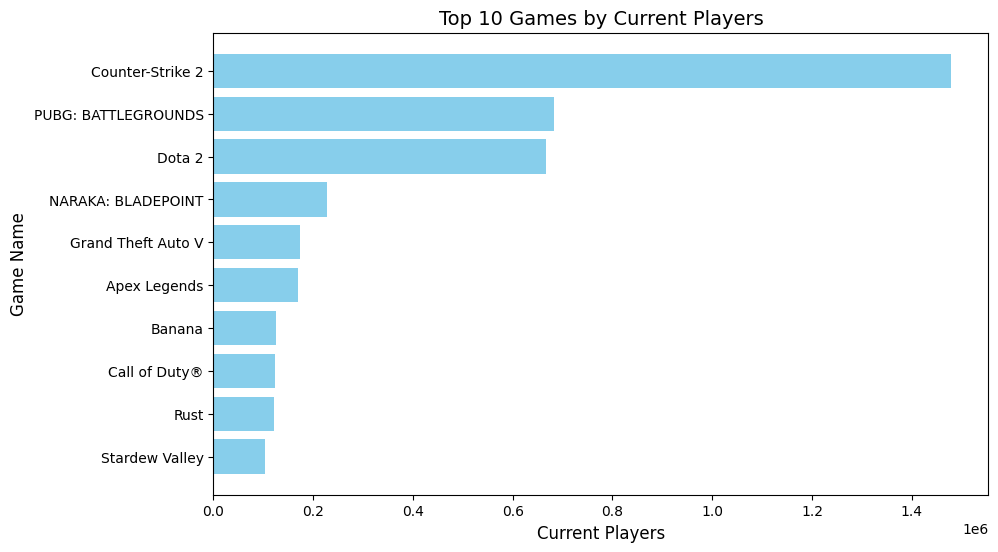

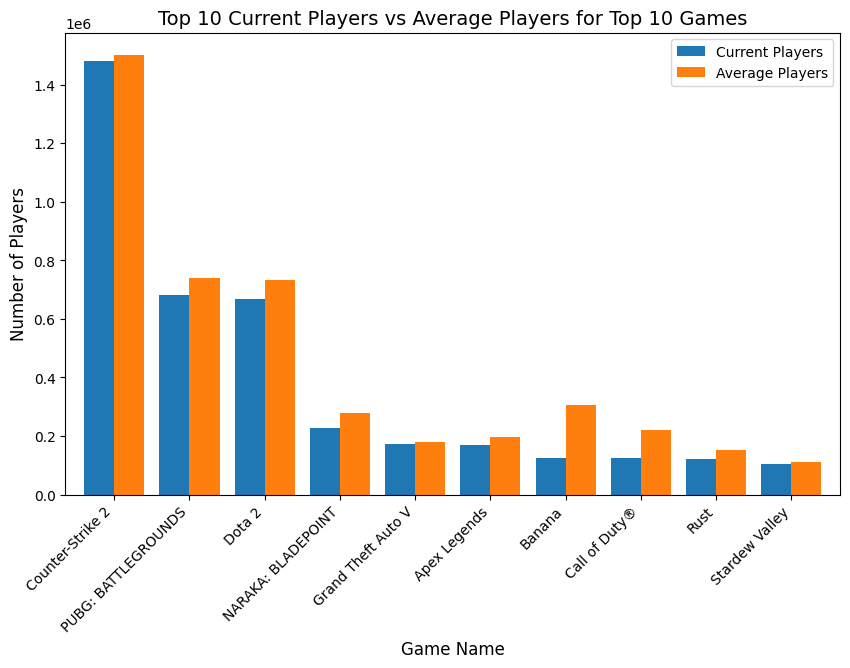

In [17]:
# 데이터세트 로드
file_path = 'clean_total_steam_data.csv'
clean_steam_data = pd.read_csv(file_path)

import matplotlib.pyplot as plt

# Step 1.1: 가장 많이 플레이한 게임 - 막대 차트
top_played_games = clean_steam_data.nlargest(10, 'Current Players')[['Name', 'Current Players']]
plt.figure(figsize=(10, 6))
plt.barh(top_played_games['Name'], top_played_games['Current Players'], color='skyblue')
plt.xlabel('Current Players', fontsize=12)
plt.ylabel('Game Name', fontsize=12)
plt.title('Top 10 Games by Current Players', fontsize=14)
plt.gca().invert_yaxis()  # Invert to show the highest on top
plt.show()

# Step 1.2: Top vs Average Players - Bar Chart
clean_steam_data['Average Players'] = (clean_steam_data['Current Players'] + clean_steam_data['Peak Players']) / 2
top_vs_avg_players = clean_steam_data.nlargest(10, 'Current Players')[['Name', 'Current Players', 'Average Players']]

top_vs_avg_players.plot(x='Name', kind='bar', figsize=(10, 6), width=0.8)
plt.title('Top 10 Current Players vs Average Players for Top 10 Games', fontsize=14)
plt.ylabel('Number of Players', fontsize=12)
plt.xlabel('Game Name', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['Current Players', 'Average Players'], fontsize=10)
plt.show()

#인기 플레이 게임: Counter-Strike 2와 Dota 2가 플레이어 수를 장악하고 있으며, 이는 게임 커뮤니티에서의 지속적인 인기를 반영합니다.
#현재 플레이어 대 평균 플레이어: 현재 플레이어 수는 평균 플레이어 수와 밀접하게 일치하는 경우가 많으며 이는 최고의 게임에 대한 지속적인 참여를 나타냅니다.

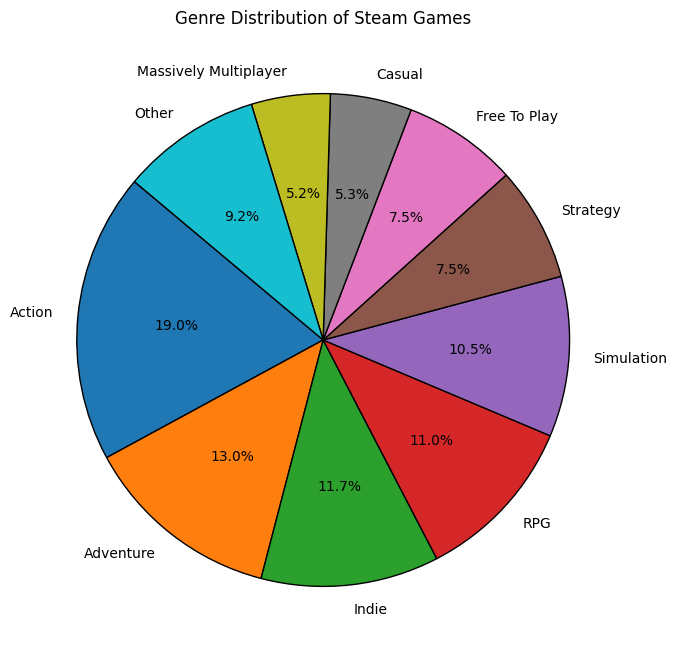

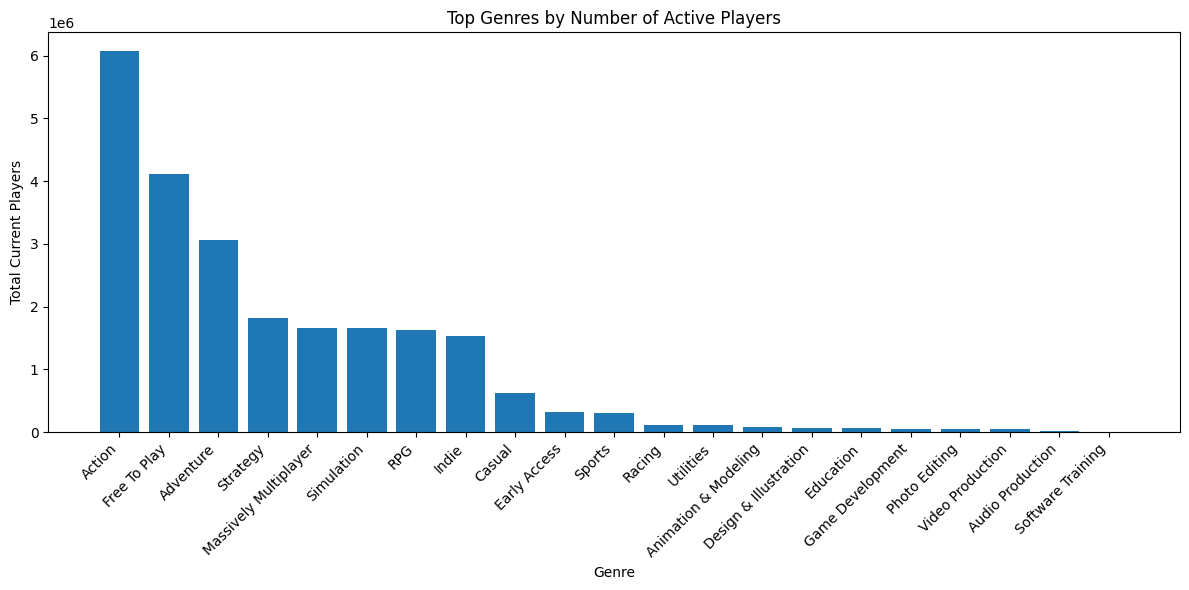

In [22]:
# 장르 분포와 폭넓은 장르에 대한 데이터를 재확인하고 재조립합니다.
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 세트 로드
file_path = 'clean_total_steam_data.csv'
clean_steam_data = pd.read_csv(file_path)

# 장르를 분할하고 모든 장르의 단일 목록을 만듭니다.
all_genres = clean_steam_data['Genre'].dropna().str.split(',').explode()

# 장르 수 및 백분율 계산
genre_counts = all_genres.value_counts()
total_genres = genre_counts.sum()
genre_percentages = (genre_counts / total_genres) * 100

# 3% 미만인 장르를 '기타'로 분류합니다.
genre_percentages['Other'] = genre_percentages[genre_percentages < 3].sum()
filtered_genres = genre_percentages[genre_percentages >= 3]
filtered_genres['Other'] = genre_percentages['Other']

# 데이터를 원형 차트로 표시
plt.figure(figsize=(10, 8))
plt.pie(
    filtered_genres,
    labels=filtered_genres.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Genre Distribution of Steam Games')
plt.show()

# 장르별 활성 플레이어 분석을 위한 장르 데이터 확장
steam_data_expanded = clean_steam_data.copy()
steam_data_expanded = steam_data_expanded.reindex(
    clean_steam_data.index.repeat(clean_steam_data['Genre'].str.split(',').apply(len))
).reset_index(drop=True)

# 장르를 단일 장르 항목으로 분할
steam_data_expanded['Genre'] = clean_steam_data['Genre'].str.split(',').explode().reset_index(drop=True)

# 장르별로 그룹화하고 각 장르의 현재 총 플레이어 수를 계산합니다.
genre_player_data = steam_data_expanded.groupby('Genre')['Current Players'].sum().reset_index()
genre_player_data = genre_player_data.sort_values(by='Current Players', ascending=False)

# 가장 활동적인 플레이어로 장르를 시각화
plt.figure(figsize=(12, 6))
plt.bar(genre_player_data['Genre'], genre_player_data['Current Players'])
plt.xlabel('Genre')
plt.ylabel('Total Current Players')
plt.title('Top Genres by Number of Active Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#액션과 어드벤처가 플레이어 선호도를 반영하여 Steam의 장르 분포를 지배하고 있는 것으로 나타났습니다.
#더 작은 틈새 장르가 전체적으로 중요한 부분을 차지하며 이는 개발자의 다양한 플레이어 관심과 시장 기회를 나타냅니다.

#차트를 보면 액션, 무료 플레이, 어드벤처 장르가 플레이어 수에서 가장 많은 비중을 차지하는 반면 전략 및 시뮬레이션은 중간 수준의 참여도를 보이고 있습니다.
#스포츠 및 크리에이티브 카테고리와 같은 틈새 장르는 소규모의 전문화된 잠재고객을 끌어들입니다.

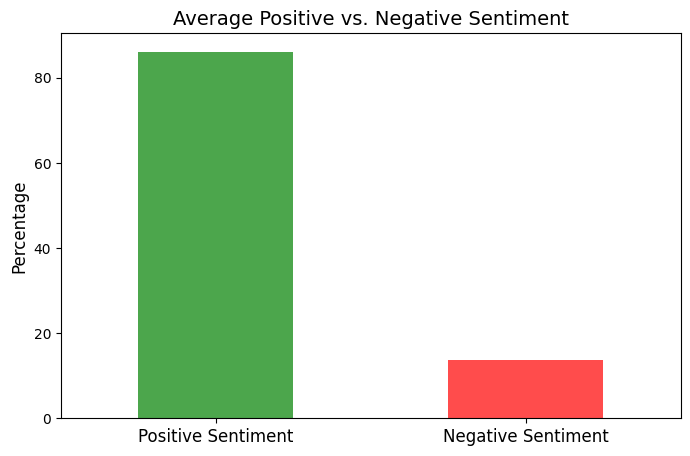

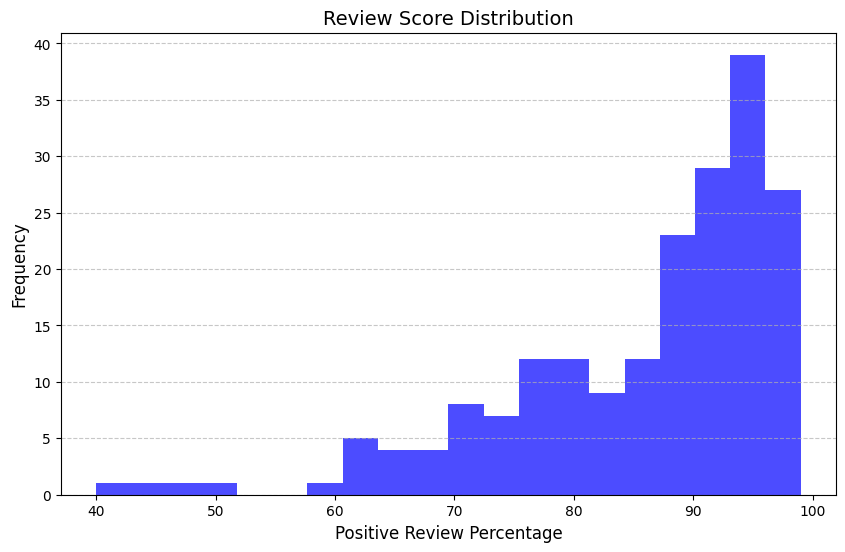

In [23]:
# Step 3.1: 감정 분석 - 긍정적인 리뷰와 부정적인 리뷰의 분포

# 데이터 세트 로드
file_path = 'clean_total_steam_data.csv'
clean_steam_data = pd.read_csv(file_path)

# '리뷰 감정'을 긍정적인 리뷰의 백분율로 가정하고 부정적인 감정을 계산합니다.
clean_steam_data['Negative Sentiment'] = 100 - clean_steam_data['Review Sentiment']

# 시각화를 위한 종합적인 감정
sentiment_aggregated = clean_steam_data[['Review Sentiment', 'Negative Sentiment']].mean()

# 감정 분포를 위한 막대 차트
plt.figure(figsize=(8, 5))
sentiment_aggregated.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Average Positive vs. Negative Sentiment', fontsize=14)
plt.ylabel('Percentage', fontsize=12)
plt.xticks([0, 1], ['Positive Sentiment', 'Negative Sentiment'], rotation=0, fontsize=12)
plt.show()

# Step 3.2: 리뷰 점수 분포 - 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(clean_steam_data['Review Sentiment'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Review Score Distribution', fontsize=14)
plt.xlabel('Positive Review Percentage', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#감정 분석:
#평균적으로 게임은 부정적인 것보다 긍정적인 감정(긍정적인 리뷰 비율)이 더 높습니다. 이는 일반적인 사용자 만족도를 반영합니다.

#평가 점수 분포:
#히스토그램을 보면 대부분의 게임이 70~90% 긍정적 범위의 리뷰 점수를 받는 것으로 나타났습니다. 이는 호의적인 사용자 피드백에 편향되어 있음을 나타냅니다.

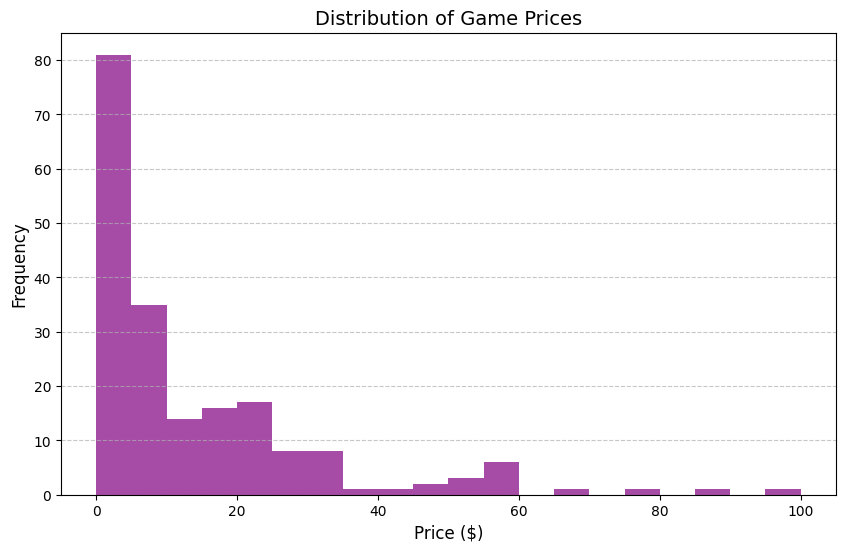

<ipython-input-26-b114ad41cd9b>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_by_price = clean_steam_data.groupby(pd.cut(clean_steam_data['Price'], bins=price_bins))['Discount'].mean()


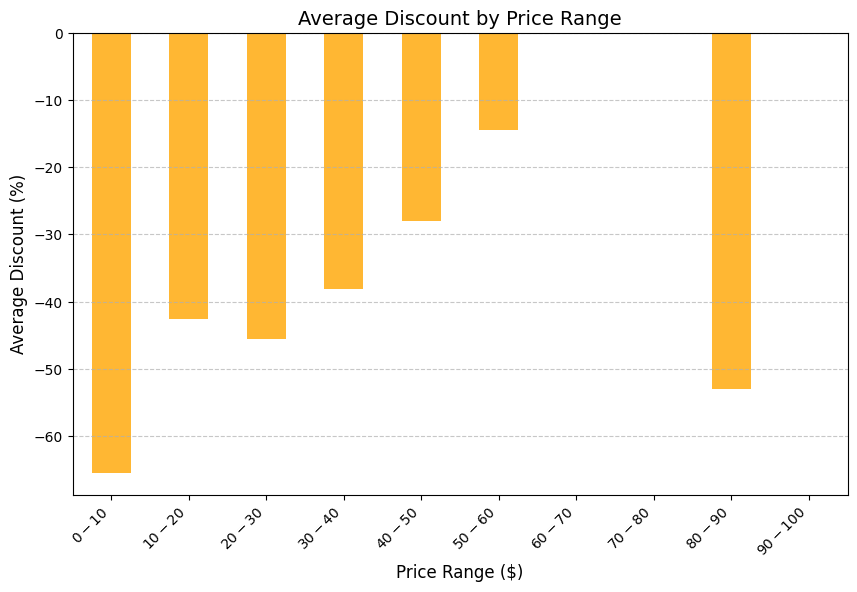

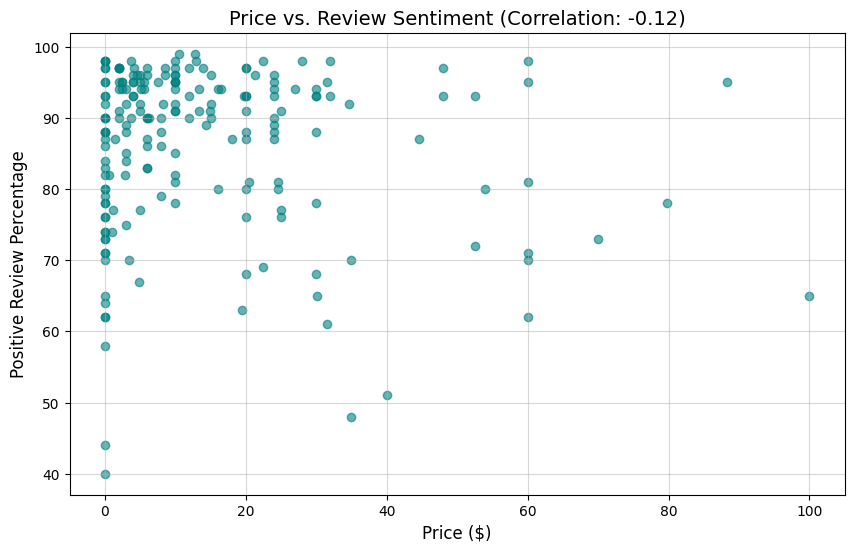

-0.12052231010272113

In [26]:
import numpy as np  # Import NumPy and alias it as 'np'

# Step 4.1: 게임 가격 동향 - 가격 분포 및 할인

# 데이터 세트 로드
file_path = 'clean_total_steam_data.csv'
clean_steam_data = pd.read_csv(file_path)

# Re-run the entire analysis, including the modified parts for better readability

# Step 4.1: Analyze the price distribution
plt.figure(figsize=(10, 6))
plt.hist(clean_steam_data['Price'], bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Game Prices', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Average discount by price range (with cleaner labels)
price_bins = np.arange(0, clean_steam_data['Price'].max() + 10, 10)  # Define bins in intervals of 10
discount_by_price = clean_steam_data.groupby(pd.cut(clean_steam_data['Price'], bins=price_bins))['Discount'].mean()

# Format bin labels for better readability
formatted_bins = [f"${int(interval.left)} - ${int(interval.right)}" for interval in discount_by_price.index]
discount_by_price.index = formatted_bins

plt.figure(figsize=(10, 6))
discount_by_price.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Average Discount by Price Range', fontsize=14)
plt.xlabel('Price Range ($)', fontsize=12)
plt.ylabel('Average Discount (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 4.2: Correlation between price and review sentiment
correlation_price_reviews = clean_steam_data[['Price', 'Review Sentiment']].corr().iloc[0, 1]

# Scatter plot for price vs. review sentiment
plt.figure(figsize=(10, 6))
plt.scatter(clean_steam_data['Price'], clean_steam_data['Review Sentiment'], alpha=0.6, color='teal')
plt.title(f'Price vs. Review Sentiment (Correlation: {correlation_price_reviews:.2f})', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Positive Review Percentage', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

correlation_price_reviews

#게임 가격 분포:
#대부분의 게임 가격은 20달러 미만이며, 저가 또는 무료 게임의 빈도가 가장 높습니다.
#60달러 이상의 가격은 드물며, 이는 고가의 게임이 적다는 것을 의미합니다.

#가격대별 평균 할인율:
#10달러 미만의 게임은 평균 할인율이 가장 높습니다(~60%).
#가격대가 높아질수록 할인율은 낮아지는 경향이 있으며, 가격대가 높아질수록 약간의 변동이 있을 수 있습니다.

#가격 대 리뷰 감정:
#가격과 리뷰 감정 사이의 상관관계는 약한 음(-0.12)으로 둘 사이에 강한 관계가 없음을 나타냅니다.
#모든 가격대에서 높은 긍정적인 리뷰 비율이 관찰되었으며, 이는 플레이어 만족도가 게임 가격에 크게 좌우되지 않음을 시사합니다.

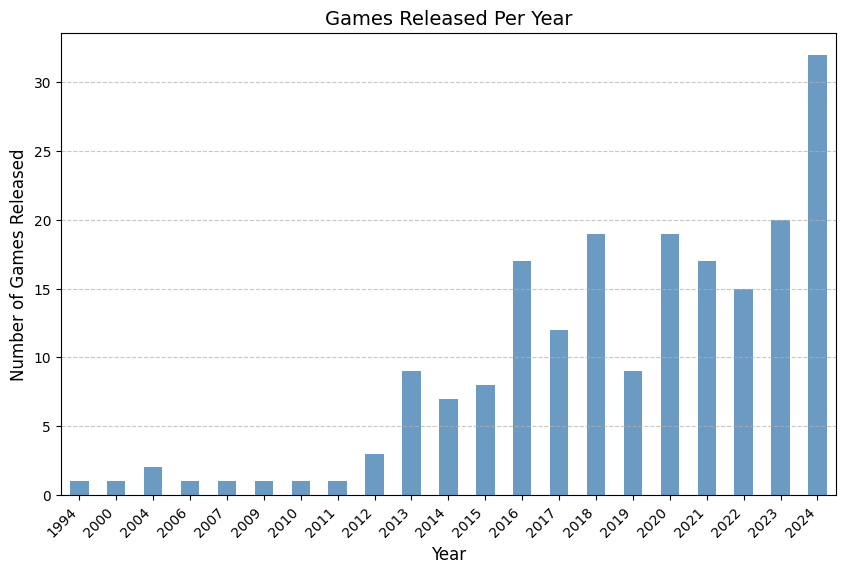

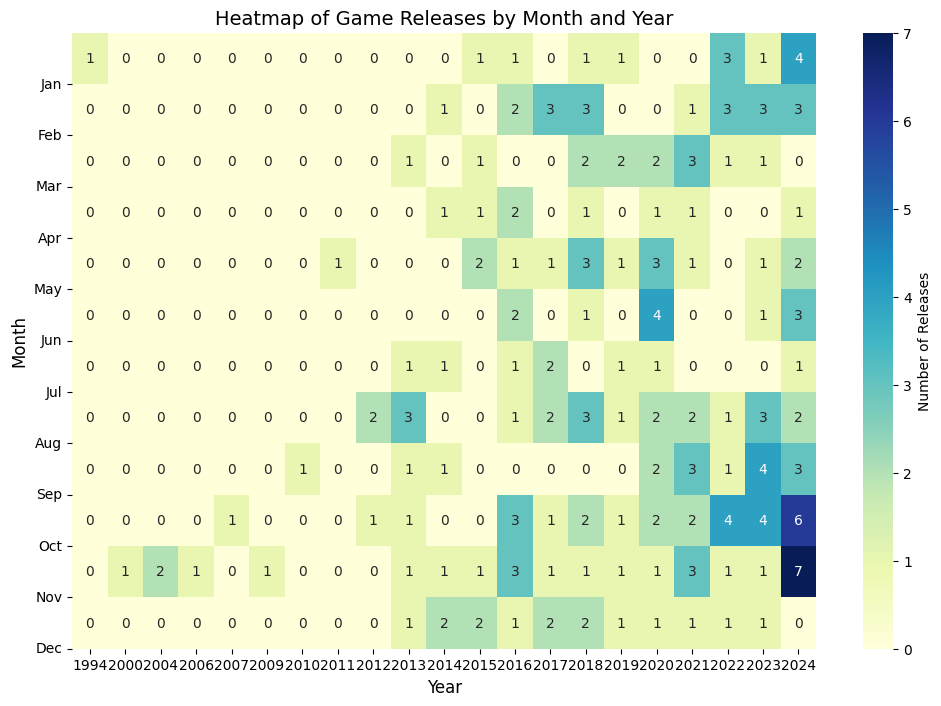

In [28]:
import numpy as np  # Import NumPy and alias it as 'np'
import seaborn as sns

# 데이터 세트 로드
file_path = 'clean_total_steam_data.csv'
clean_steam_data = pd.read_csv(file_path)

# '출시일'이 날짜/시간 형식인지 확인하세요.
clean_steam_data['Release Date'] = pd.to_datetime(clean_steam_data['Release Date'], errors='coerce')

# Retry Step 5.1: 매년 출시되는 게임
games_per_year = clean_steam_data['Release Date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 6))
games_per_year.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Games Released Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Games Released', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Retry Step 5.2: 출시 시즌 동향 - 월별 출시 히트맵
clean_steam_data['Release Month'] = clean_steam_data['Release Date'].dt.month
releases_by_month_year = clean_steam_data.groupby(['Release Month', clean_steam_data['Release Date'].dt.year]).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(releases_by_month_year, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Number of Releases'})
plt.title('Heatmap of Game Releases by Month and Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.yticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

#연간 출시되는 게임 수:
#출시된 게임 수는 플랫폼이나 시장 동향에 따라 특정 연도에 눈에 띄게 정점을 찍는 등 변동이 심했습니다.

#출시 시즌 동향:
#히트맵을 보면 게임 출시가 11월, 12월 등 특정 월에 집중되어 휴일 판매를 활용할 가능성이 높은 것으로 나타났습니다.

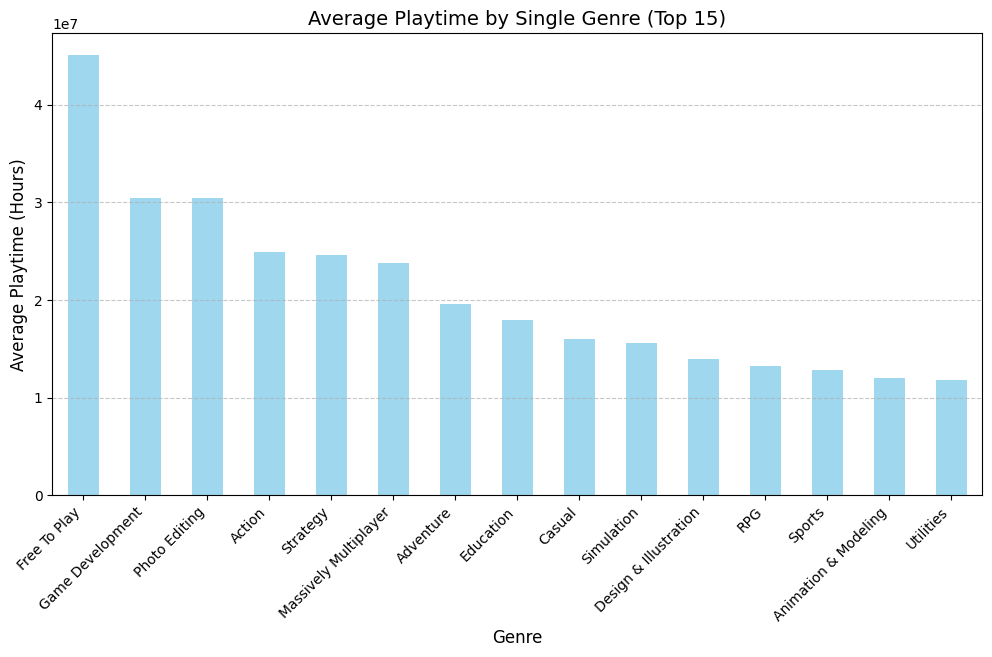

<ipython-input-30-693af205f932>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_playtime_by_price = single_genre_data.groupby(pd.cut(single_genre_data['Price'], bins=price_bins))['Hours Played'].mean()


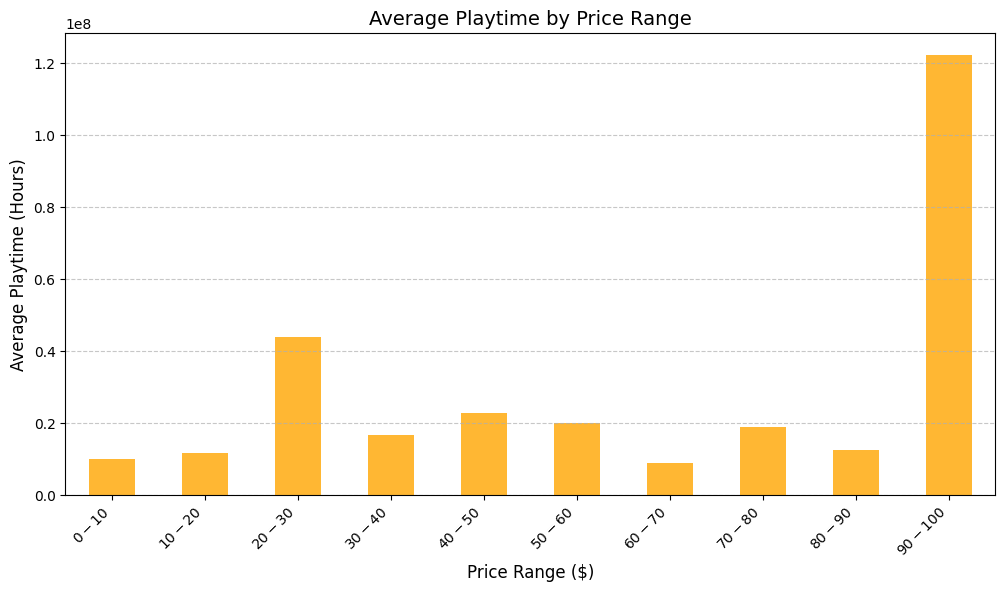

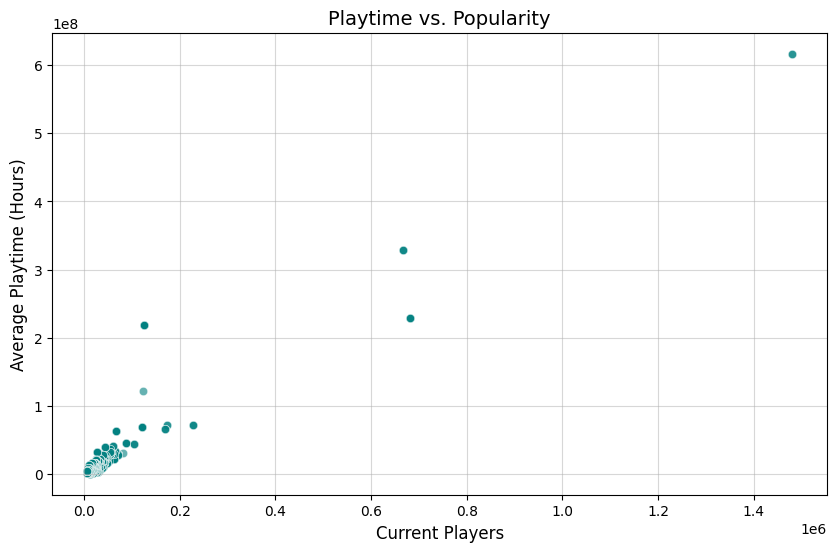

In [30]:
# 데이터 세트 로드
file_path = 'clean_total_steam_data.csv'
clean_steam_data = pd.read_csv(file_path)

# Step 1: 장르를 하나의 장르로 분류
single_genre_data = clean_steam_data.copy()
single_genre_data = single_genre_data.assign(Genre=single_genre_data['Genre'].str.split(','))
single_genre_data = single_genre_data.explode('Genre').reset_index(drop=True)

# Step 2: 단일 장르별 평균 플레이 시간
avg_playtime_by_single_genre = single_genre_data.groupby('Genre')['Hours Played'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_playtime_by_single_genre.head(15).plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Average Playtime by Single Genre (Top 15)', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Playtime (Hours)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 3: 가격대별 평균 플레이 시간(단일 장르 기준)
price_bins = np.arange(0, single_genre_data['Price'].max() + 10, 10)  # Define bins in intervals of 10
avg_playtime_by_price = single_genre_data.groupby(pd.cut(single_genre_data['Price'], bins=price_bins))['Hours Played'].mean()

# 더 나은 가독성을 위해 빈 라벨 형식 지정
formatted_bins = [f"${int(interval.left)} - ${int(interval.right)}" for interval in avg_playtime_by_price.index]
avg_playtime_by_price.index = formatted_bins

plt.figure(figsize=(12, 6))
avg_playtime_by_price.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Average Playtime by Price Range', fontsize=14)
plt.xlabel('Price Range ($)', fontsize=12)
plt.ylabel('Average Playtime (Hours)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 4: 플레이 시간과 인기도(현재 플레이어)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=single_genre_data['Current Players'], y=single_genre_data['Hours Played'], alpha=0.6, color='teal')
plt.title('Playtime vs. Popularity', fontsize=14)
plt.xlabel('Current Players', fontsize=12)
plt.ylabel('Average Playtime (Hours)', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

#단일 장르별 평균 재생 시간:
#무료 플레이 및 게임 개발 장르는 장기적인 참여를 반영하여 평균 플레이 시간이 가장 높습니다.
#액션 및 전략 장르도 높은 순위를 차지하여 확장된 게임 세션에 대한 인기를 강조합니다.

#가격대별 평균 플레이 시간:
#$90~$100 가격의 프리미엄 게임이 평균 플레이 시간을 압도하는데, 이는 아마도 광범위한 콘텐츠 때문일 것입니다.
#$20~$30 가격의 게임도 합리적인 가격과 콘텐츠 깊이의 균형을 유지하면서 주목할만한 참여도를 보여줍니다.

#플레이 시간과 인기도:
#인기(현재 플레이어)와 플레이 시간 사이에는 직접적인 연관성이 없습니다.
#많이 플레이되는 일부 게임은 참여 시간이 낮아 캐주얼 또는 짧은 세션 게임 플레이를 제안합니다.


<ipython-input-32-4bd7e4ac1bfb>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_analysis = clean_steam_data.groupby('Discount Range').agg(


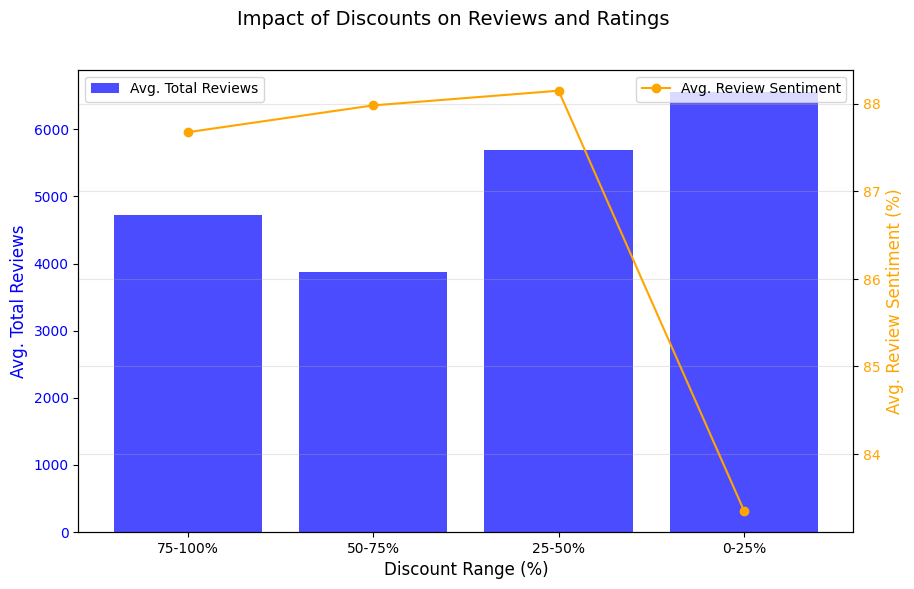

In [32]:

import seaborn as sns

# 데이터 세트 로드
file_path = 'clean_total_steam_data.csv'
clean_steam_data = pd.read_csv(file_path)

# Step 1: 할인 범위별로 데이터 그룹화
discount_bins = [-100, -75, -50, -25, 0]  # Define discount ranges
clean_steam_data['Discount Range'] = pd.cut(clean_steam_data['Discount'], bins=discount_bins, labels=['75-100%', '50-75%', '25-50%', '0-25%'])

# Step 2: 할인 범위별 평균 총 리뷰수 및 평균 리뷰 감정을 계산합니다.
discount_analysis = clean_steam_data.groupby('Discount Range').agg(
    Avg_Reviews=('Total Reviews', 'mean'),
    Avg_Rating=('Review Sentiment', 'mean')
).sort_index()

# Step 3: 두 측정항목에 대한 결과를 플롯합니다.
fig, ax1 = plt.subplots(figsize=(10, 6))

# 플롯 평균 리뷰
ax1.bar(discount_analysis.index, discount_analysis['Avg_Reviews'], alpha=0.7, label='Avg. Total Reviews', color='blue')
ax1.set_xlabel('Discount Range (%)', fontsize=12)
ax1.set_ylabel('Avg. Total Reviews', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 보조 y축의 오버레이 평균 등급
ax2 = ax1.twinx()
ax2.plot(discount_analysis.index, discount_analysis['Avg_Rating'], marker='o', color='orange', label='Avg. Review Sentiment')
ax2.set_ylabel('Avg. Review Sentiment (%)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례
fig.suptitle('Impact of Discounts on Reviews and Ratings', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

#총 리뷰:
#적당한 할인(25~50%)을 적용한 게임은 평균 리뷰 수가 가장 높습니다.
#매우 높은 할인(75~100%)은 여전히 ​​상당한 수의 리뷰를 받지만 할인이 적으면 개수가 약간 감소합니다.

#감정 검토:
#리뷰 감정은 모든 할인 범위에서 상대적으로 높은 수준(86% 이상)을 유지하고 있습니다.
#할인율이 낮은(0~25%) 게임의 경우 리뷰 감정이 눈에 띄게 감소했습니다.